In [1]:
import torch
import json
import numpy as np
import  spdnetwork.nn as nn_spd

from spdnetwork.optimizers import  MixOptimizer 
from spdnetwork.nn import LogEig
from Utils import get_fold_of_data
from DatasetManagement import DatasetManagement
from Models import   Contrastive_CB3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2






/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
target_shape = (12, 32, 32)
sequence_embedding_features = 18432

weights_path = '/data/Results/Experiments_Contrastive_CB3_17_Mayo/models/mertash_contrastive_fold_4.pt'
model = Contrastive_CB3(device, target_shape, sequence_embedding_features, 'contrastive')
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))



<All keys matched successfully>

In [3]:
x_train, x_validation ,y_train, y_validation, ids_train, ids_val, indexdes= get_fold_of_data(4, None)

val_data = DatasetManagement(x_validation, y_validation)
train_data = DatasetManagement(x_train, y_train)

val_loader = torch.utils.data.DataLoader(
    dataset = val_data,
    shuffle = False,
    batch_size = 32,
    pin_memory=False
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    shuffle = False,
    batch_size = 32,
    pin_memory=False
)

^^^^^^^^^^Entrenando con todo el Dataset^^^^^^^^^^
Entrenando sin porcentajes


In [4]:
#OBTENER TODAS LAS ACTIVACIONES DE UN FOWARD PASS

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output
    return hook

activations = {}
all_activations_t2 = []
all_activations_adc = []
all_activations_bval = []
all_labels = [] 

# Registro el hook en la capa 17
model.t2_conv_branch[17].register_forward_hook(get_activation('t2_conv_branch'))
model.adc_conv_branch[17].register_forward_hook(get_activation('adc_conv_branch'))
model.bval_conv_branch[17].register_forward_hook(get_activation('bval_conv_branch'))

model.eval()
model.to(device)

with torch.no_grad():
    val_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        for j in range(len(inputs)):
            inputs[j] = inputs[j].to(device).type(torch.float)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        all_labels.append(labels)
        
        all_activations_t2.append(activations['t2_conv_branch'])
        all_activations_adc.append(activations['adc_conv_branch'])
        all_activations_bval.append(activations['bval_conv_branch'])
        


concatenated_activations = []

for t2_act, adc_act, bval_act in zip(all_activations_t2, all_activations_adc, all_activations_bval):
    concatenated = torch.cat([t2_act, adc_act, bval_act], dim=1)
    concatenated_activations.append(concatenated)
    
print(concatenated_activations[7].shape) # torch.Size([28, 96, 6, 8, 8])
print(len(concatenated_activations)) # 8


all_labels_tensor = torch.cat(all_labels, dim=0)      
print(all_labels_tensor.shape) 


torch.Size([28, 96, 6, 8, 8])
8
torch.Size([252, 1])


In [5]:
#GENERAR LAS MATRICES SPD'S

def get_spd(acts, type="gramm"):
    
    vect_acts = acts
    # h, w, d = acts.shape
    # vect_acts = acts.reshape(h * w, d)
    if type == "gramm":
        spd = vect_acts.T @ vect_acts
    elif type == "corr":
        spd = np.corrcoef(vect_acts.T)
    elif type == "cov":
        spd = np.cov(vect_acts.T)
    return spd

all_spds = []

# Recorro los 8 lotes de 32
for batch in concatenated_activations:  # batch = [32, 96, 6, 8, 8]
    batch_size, channels, depth, height, width = batch.shape
    
    # Iterar sobre cada muestra en el lote
    for i in range(batch_size):
        sample = batch[i]  # sample = [96, 6, 8, 8]
        #print(f"Sample shape: {sample.shape}")
        
        sample_reshape = sample.permute(1, 2, 3, 0).reshape(-1, channels) # sample_reshape = torch.Size([384, 96])
        # print(sample_reshape.shape)
        
        activation_np = sample_reshape.cpu().numpy()
        
        spd_matrix = get_spd(activation_np, type="gramm")
        
        all_spds.append(spd_matrix)
            
        


all_spds_tensor = torch.tensor(all_spds)
print(all_spds_tensor.shape)
print(all_spds_tensor[0].shape)


torch.Size([252, 96, 96])
torch.Size([96, 96])


/tmp/ipykernel_668263/254761008.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/torch/csrc/utils/tensor_new.cpp:245.)
  all_spds_tensor = torch.tensor(all_spds)


In [6]:
all_spds_tensor[1]

tensor([[ 3.4045,  0.2378,  1.6387,  ...,  1.2042,  1.1052, -0.9954],
        [ 0.2378,  7.0363,  1.6566,  ...,  1.0207, -4.6884,  0.4241],
        [ 1.6387,  1.6566,  5.3437,  ...,  0.6873, -3.1771, -0.2724],
        ...,
        [ 1.2042,  1.0207,  0.6873,  ...,  3.5079,  1.7890, -0.2018],
        [ 1.1052, -4.6884, -3.1771,  ...,  1.7890, 18.6412,  0.9641],
        [-0.9954,  0.4241, -0.2724,  ..., -0.2018,  0.9641,  2.6614]],
       dtype=torch.float64)

In [7]:
#MAPEAR AL PLANO TANGENTE
# Función para obtener las matrices SPD reconstruidas
def get_reconstructed_spd(all_spds_tensor):
    num_spds, x, y = all_spds_tensor.shape
    
    reconstructed_spds = torch.zeros(num_spds, x, y)
    
    for i in range(num_spds):
        spd = all_spds_tensor[i]
        eigenvalues, eigenvectors = torch.linalg.eigh(spd)
        
        epsilon = 1e-5
        log_eigenvalues = torch.log(eigenvalues.clamp(min=epsilon))
        
        reconstructed_spd = eigenvectors @ torch.diag(log_eigenvalues) @ eigenvectors.T
        
        reconstructed_spds[i] = reconstructed_spd
    
    return reconstructed_spds


reconstructed_spds = get_reconstructed_spd(all_spds_tensor)


print(reconstructed_spds.shape)  #reconstructed_spds = torch.Size([252, 96, 96])

torch.Size([1043, 96, 96])


In [8]:
import torch

def get_reconstructed_spd_upper_triangular(reconstructed_spds):
    n_samples, n_dim, _ = reconstructed_spds.shape
    
    upper_triangular_flat = []
    
    for i in range(n_samples):
        spd = reconstructed_spds[i]
        
        upper_triangular = torch.masked_select(torch.triu(spd, diagonal=1), torch.triu(torch.ones_like(spd), diagonal=1).bool())
        
        upper_triangular_flat.append(upper_triangular)
    
    upper_triangular_flat_tensor = torch.stack(upper_triangular_flat)
    
    return upper_triangular_flat_tensor

upper_triangular_flat = get_reconstructed_spd_upper_triangular(reconstructed_spds)
print(upper_triangular_flat.shape)  #upper_triangular_flat = [252, 4560]


torch.Size([1043, 4560])


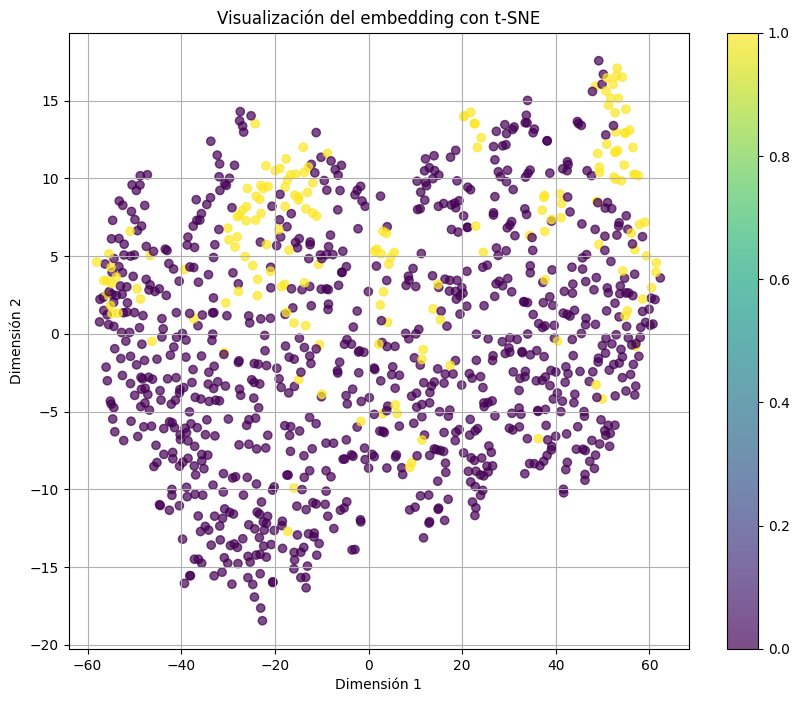

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que tienes upper_triangular_flat con las dimensiones correctas

# Aplicar t-SNE para reducir la dimensionalidad a 2 dimensiones
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(upper_triangular_flat.numpy())

# Obtener los labels correspondientes a los embeddings
# Suponiendo que all_labels_tensor contiene los labels correspondientes
labels = all_labels_tensor.numpy()

# Crear una figura
plt.figure(figsize=(10, 8))

# Graficar los puntos t-SNE, coloreados por los labels
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)

plt.title('Visualización del embedding con t-SNE')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(True)
plt.show()
